In [1]:
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE

from pprint import pprint

%matplotlib inline

Let's begin with simply looking at data

In [2]:
df = pd.read_csv("y_posts.csv")
df.head()

,UserID,PostID,Age,Country,Followers,PostType,PostHour,PostWeekday,Likes,Shares,Comments,EngagementScore
0,997,0,21,Canada,67,Text,22,Monday,21,4,2,0.447761
1,48,1,47,Canada,407,Video,18,Monday,20,5,4,0.105651
2,301,2,18,USA,174,Text,17,Monday,18,8,4,0.252874
3,880,3,22,UK,53,Video,6,Monday,116,7,10,3.056604
4,189,4,31,France,3,Text,8,Monday,24,5,1,11.666667


In [3]:
df.sort_values("EngagementScore").head()

,UserID,PostID,Age,Country,Followers,PostType,PostHour,PostWeekday,Likes,Shares,Comments,EngagementScore
3134,170,3134,41,Canada,1490,Text,12,Friday,23,1,2,0.017450
4939,170,4939,41,Canada,1490,Text,17,Wednesday,26,1,1,0.018121
3107,170,3107,41,Canada,1490,Video,11,Thursday,17,3,4,0.020134
4810,170,4810,41,Canada,1490,Text,22,Friday,16,3,3,0.020134
2664,170,2664,41,Canada,1490,Video,21,Sunday,17,6,2,0.022148


In [4]:
df.sort_values("EngagementScore", ascending=False).head()

,UserID,PostID,Age,Country,Followers,PostType,PostHour,PostWeekday,Likes,Shares,Comments,EngagementScore
2872,627,2872,47,USA,2,Video,22,Monday,75,6,53,121.000000
4653,627,4653,47,USA,2,Image,9,Friday,13,7,52,89.000000
4957,607,4957,25,Spain,3,Image,12,Thursday,19,7,54,64.666667
2097,221,2097,36,UK,3,Image,14,Thursday,14,3,51,57.666667
1182,627,1182,47,USA,2,Text,21,Monday,79,6,4,53.000000


Given the sorted values of DataFrame, we can see, that the biggest score is given to rows with high `Followers`, `Likes` and/or `Comments`. Also the name of the metric suggests, that it is meant to measure interaction of the user with the post. In this sense fields `Age` and `Country` are highly unlikely to be useful. 
I started talking about what we can understand about a metric, given its name. So far the intuituin and hypothesis I can make about our target value are:
  * `EngagementScore` is a metric, which means it probably has quite simple form, like `(A + B) / C` or similar.
  * It is apparent that likes, followers and comments are important for this metric
  * age, country are unlikely to be useful
  * post type, post hour and post weekday might have some impact but it is unclear and should be tested

I am pretty sure that we can have quite precise linear regression model, but we need more work with data. Let's look at distribution of `EngagementScore` first

count    5000.000000
mean        1.547303
std         4.254233
min         0.017450
25%         0.181470
50%         0.440183
75%         1.233675
max       121.000000
Name: EngagementScore, dtype: float64


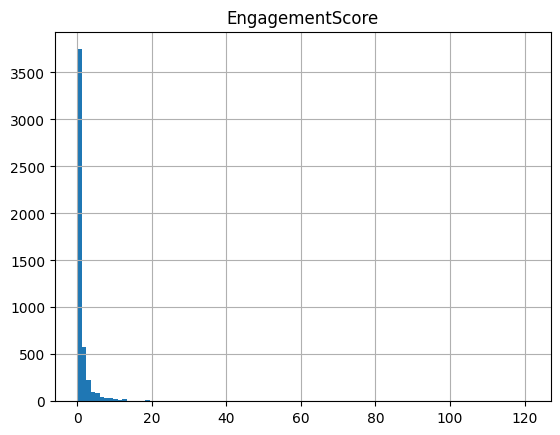

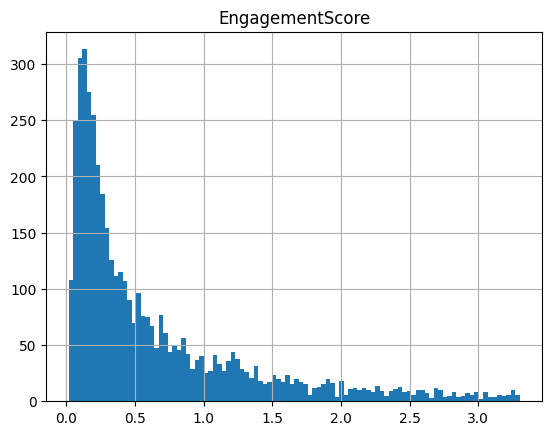

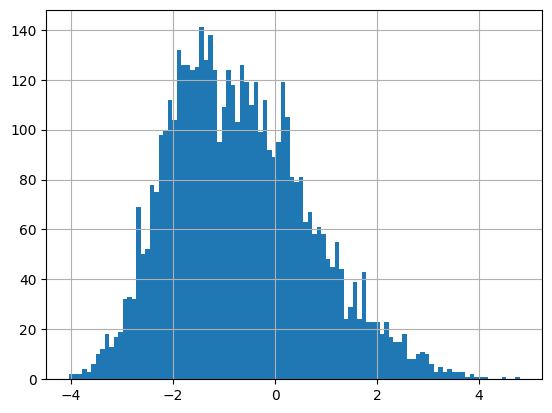

count    5000.000000
mean       -0.677297
std         1.377209
min        -4.048435
25%        -1.706666
50%        -0.820564
75%         0.209998
max         4.795791
Name: EngagementScore, dtype: float64


In [5]:
print(df.EngagementScore.describe())
df.hist(
    "EngagementScore",
    bins=100,
)
plt.show()
# looks like a lot of outliers
df.sort_values("EngagementScore", ascending=True).head(int(df.shape[0] * 0.9)).hist(
    "EngagementScore",
    bins=100,
)
plt.show()
# looks like lognormal
df.sort_values("EngagementScore", ascending=True).EngagementScore.apply(np.log).hist(
    bins=100,
)
plt.show()
# looks like normal or bi-variate normal
print(
    df.sort_values("EngagementScore", ascending=True)
    .EngagementScore.apply(np.log)
    .describe()
)

df_normal = df.copy()
df_normal.EngagementScore = df_normal.EngagementScore.apply(np.log)

We can see, that originally the distribution of target variable is log-normal. After applying log it gets very close to normal distribution (or maybe bi-modal normal)
I'll keep log of target and use it for prediction in the next steps
Let's look at other features

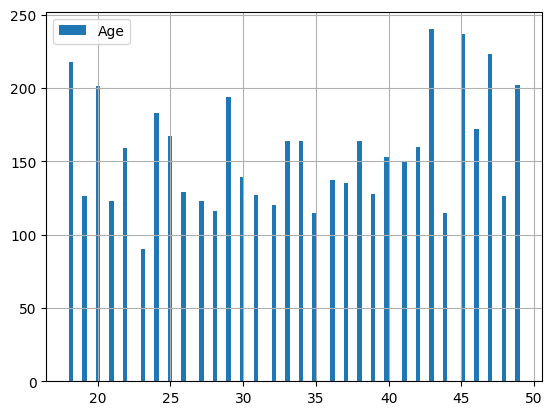

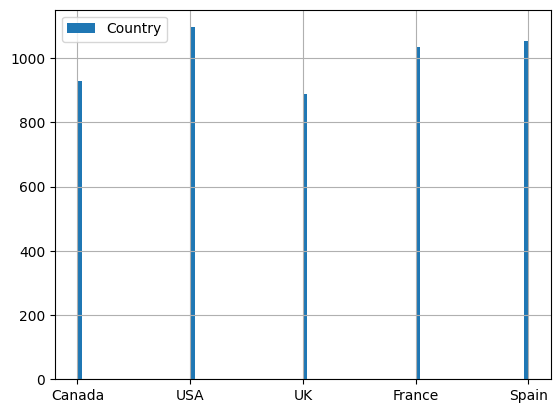

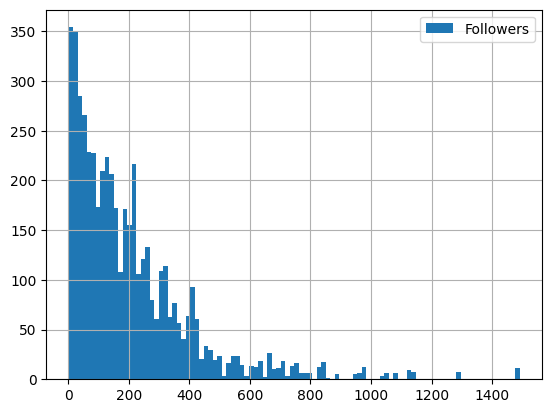

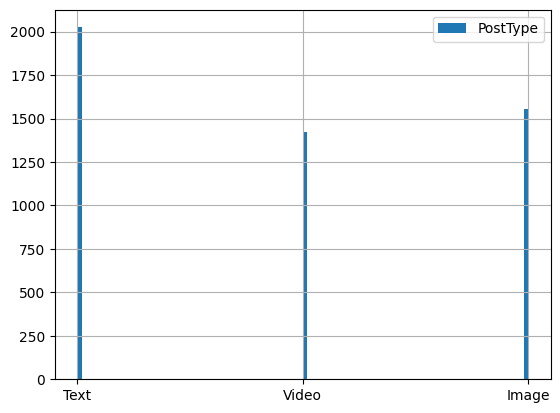

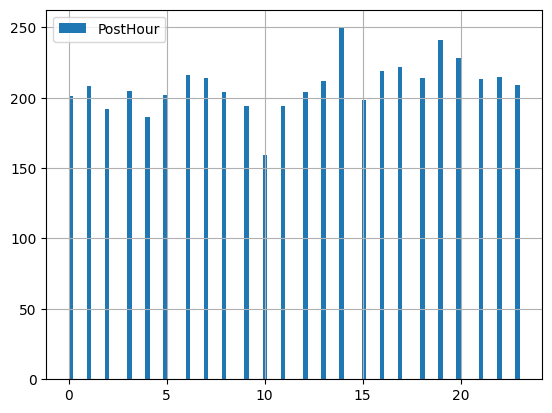

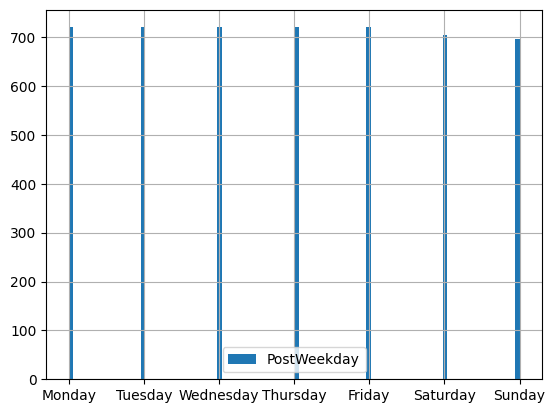

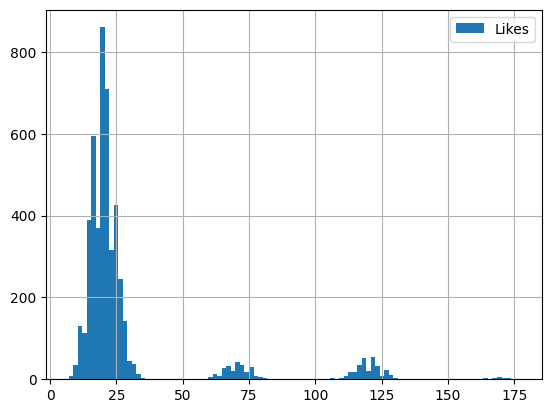

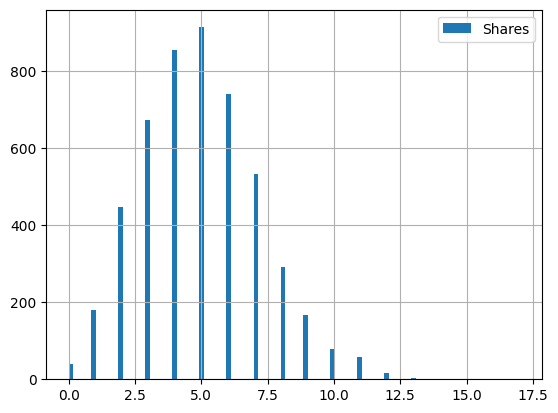

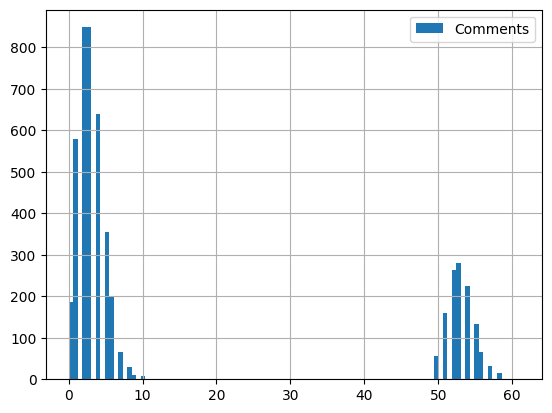

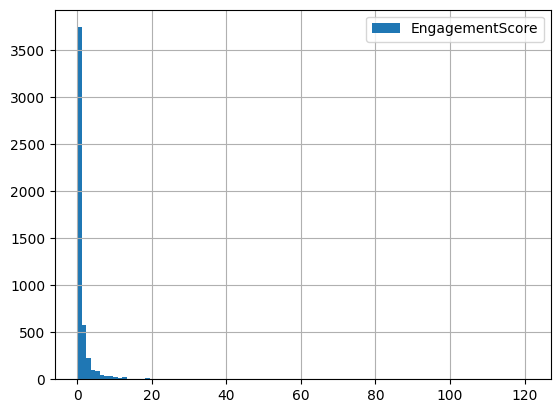

In [6]:
columns = list(df.columns)
columns.remove("UserID")
columns.remove("PostID")
for c in columns:
    df[c].hist(bins=100, legend=True)
    plt.show()

Most of the variables look like normal, multi-modal normal or uniform distributions. But `Followers` looks like poisson or log-normal so we might want to apply log to this column.
Let's proceed with looking at how different variables contribute to target. I will start with simple Spearman correlation. It should tell us if there is a monotonic correlation between variables

In [7]:
df_normal.drop(["UserID", "PostID"], axis=1).corr(
    method="spearman", numeric_only=True
).iloc[-1:]

,Age,Followers,PostHour,Likes,Shares,Comments,EngagementScore
EngagementScore,-0.02622,-0.803716,0.033509,0.162348,0.059267,0.404625,1.0


We can see that `Followers`, `PostHour`, `Likes` and `Comments` have quite high correlation. Correlation doesn't proove the causation but it shows us where to look.
To be honest, at this point I started experimenting with linear regression and lass feature selection, and was getting R2 score of around 0.72. So I stopped and looked some more at the features with mutual information and recursive feature elimination.
Here I start using 5 cross-validation splits, with fixed random seed and I inspect features only on the first training fold. Just in case, to prevent any leak from the test data. But all the models showed that performance on different folds is very similar, which means that data distribution is not skewed and it should be safe to make assumptions on some particular fold.

In [8]:
drop_labels = ["UserID", "PostID", "EngagementScore"]
df_numeric = df_normal.drop(drop_labels, axis=1)
one_hot_labels = ["Country", "PostType", "PostWeekday"]
for c in one_hot_labels:
    feat_list = list(sorted(list(set(df_numeric[c]))))
    df_numeric[c] = df_numeric[c].apply(lambda x: feat_list.index(x))

discrete_mask = np.array([c in one_hot_labels for c in df_numeric.columns])

X = KFold(
    n_splits=5,
    random_state=42,
    shuffle=True,
).split(df_numeric, df_normal[df_normal.columns[-1:]])
mi_scores = []
for train_idx, test_idx in X:
    train_data = df_numeric.to_numpy()[train_idx]

# for mutual information it is ok to leave discrete features unprocessed
mi_score = mutual_info_regression(
    train_data,
    df_normal["EngagementScore"][train_idx],
    discrete_features=discrete_mask,
    n_neighbors=7,
)
mi_scores.append(mi_score)
res = list(zip(df_numeric.columns, mi_score))
res_dict = sorted(res, key=lambda x: x[1])

# for classifiers it is better to change discrete variables to one-hot
# However it will be much more expensive to compute RFE
df_numeric = pd.concat(
    [df_numeric, pd.get_dummies(df_normal[one_hot_labels], dtype=float)], axis=1
)
train_data = df_numeric.to_numpy()[train_idx]
lasso = GradientBoostingRegressor()
rfe = RFE(estimator=lasso, n_features_to_select=4, step=1)
rfe.fit(train_data, df_normal["EngagementScore"][train_idx])
ranking = sorted(zip(df_numeric.columns, rfe.ranking_), key=lambda x: x[1])
print("MI scores")
pprint(res_dict[::-1])
print("-" * 80)
print("RFE ranking")
pprint(ranking)

MI scores
[('Followers', 1.2469138268183189),
 ('Comments', 0.16014339852910808),
 ('Age', 0.07677025119620051),
 ('Likes', 0.04127642780377627),
 ('PostHour', 0.0164938976946587),
 ('PostWeekday', 0.011610238833980269),
 ('Shares', 0.010521890928028022),
 ('Country', 0.00806049062870473),
 ('PostType', 0.007773501227880342)]
--------------------------------------------------------------------------------
RFE ranking
[('Followers', 1),
 ('Likes', 1),
 ('Shares', 1),
 ('Comments', 1),
 ('Age', 2),
 ('PostHour', 3),
 ('PostWeekday_Tuesday', 4),
 ('PostWeekday_Thursday', 5),
 ('PostWeekday_Sunday', 6),
 ('PostWeekday_Saturday', 7),
 ('PostWeekday_Monday', 8),
 ('PostWeekday_Friday', 9),
 ('PostWeekday', 10),
 ('PostType_Video', 11),
 ('PostType_Text', 12),
 ('PostType', 13),
 ('Country', 14),
 ('PostWeekday_Wednesday', 15),
 ('PostType_Image', 16),
 ('Country_Canada', 17),
 ('Country_USA', 18),
 ('Country_France', 19),
 ('Country_UK', 20),
 ('Country_Spain', 21)]


From scores above we can see, that for mutual information scores the biggest values are for `Followers`, `Comments`, `Age`, `PostHours`, `Likes`. For me from this results it is not clear why `Age` and `PostHour` are so high. Maybe it is because some age group make better posts at some particular time of day (like after work or school). I still don't think that age and time of day is used for calculating metric. And recursive feature elimination shows that `PostHour` and `Age` are ranked lower than `Followers`, `Likes`, `Shares` and `Comments`, which makes sense to me. Here I used `GradientBoosting` for RFE, instead of linear regression because it is much more powerful, robust and non-linear. But given all the previous information I came up to simple linear regression model, that performs more or less good. Bellow there are several models, including linear regression. Some parameters I found by hand, they are not optimal, proper hyperparameter search can give somewhat better results. I still want to find the exact function of metric, so complex models like SVR and GradientBoosting won't help much
I use 2 types of scores, R2, which is used by sklearn, and which tells the amount of explained variance, and mean absolute error, which gives better understanding of error.

In [9]:
drop_labels = [
    "UserID",
    "PostID",
    "Country",
    "PostType",
    "PostWeekday",
    "EngagementScore",
    "PostHour",
    "Age",
]

df_numeric = df_normal.drop(drop_labels, axis=1)

# applying log is really important for linear and SVR models
# I wouldn't notice it without feature selection steps above
df_numeric["Followers"] = df_numeric["Followers"].apply(np.log)

target = df_normal["EngagementScore"].to_numpy()

for r in [
    LinearRegression,
    lambda: Lasso(alpha=0.05),
    lambda: SVR(C=100),
    lambda: GradientBoostingRegressor(),
]:
    X = KFold(
        n_splits=5,
        random_state=42,
        shuffle=True,
    ).split(df_numeric, df_normal[df_normal.columns[-1:]])
    scores = []
    mae_scores = []
    for train_idx, test_idx in X:
        reg_model = r()

        train_target = target[train_idx]

        train_data = df_numeric.to_numpy()[train_idx]
        test_data = df_numeric.to_numpy()[test_idx]

        reg_model.fit(train_data, train_target)
        test_target = target[test_idx]
        score = reg_model.score(test_data, test_target)
        scores.append(score)
        # For MAE I revert log of target variable, to know the error in relation to original target variable
        mae_score = np.mean(
            np.abs(np.exp(reg_model.predict(test_data)) - np.exp(target[test_idx]))
        )
        mae_scores.append(mae_score)
    print("Estimator", reg_model)
    print("Scores", scores, "average:", np.mean(scores))
    print("MAE Scores", mae_scores, "MAE average:", np.mean(mae_scores))
    print("-" * 200)

Estimator LinearRegression()
Scores [0.9850875836741539, 0.9848730968558521, 0.985679582355991, 0.9859429142972034, 0.9863007067774089] average: 0.9855767767921219
MAE Scores [0.21941692902913656, 0.22706428804986406, 0.24343875645118526, 0.1975354209741237, 0.2508739906164295] MAE average: 0.2276658770241478
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Estimator Lasso(alpha=0.05)
Scores [0.9838003304327234, 0.9842459077711583, 0.9838920484204019, 0.9846835399808671, 0.9851195576616573] average: 0.9843482768533616
MAE Scores [0.23485494787452207, 0.2443708223991751, 0.297604347929685, 0.24978487771744654, 0.26326150190915687] MAE average: 0.2579752995659971
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

From the results aboce, SVR works the best, GradientBoosting follows and linear regression is the worst. Still, linear regression explains 98.5% of variance. And it can be improved further, simply by adding some relations between variables (`A/B`)

In [10]:
drop_labels = [
    "UserID",
    "PostID",
    "Country",
    "PostType",
    "PostWeekday",
    "EngagementScore",
    "PostHour",
    "Age",
]

df_numeric = df_normal.drop(drop_labels, axis=1)

df_numeric["Followers"] = df_numeric["Followers"].apply(np.log)
permutations = [
    (df_numeric[c] / (df_numeric[cc] + 1e-8)).rename(f"{c}/{cc}")
    for c in df_numeric.columns
    for cc in df_numeric.columns
    if c != cc
]

df_numeric = pd.concat([df_numeric] + permutations, axis=1)

target = df_normal["EngagementScore"].to_numpy()

for r in [
    LinearRegression,
    lambda: SVR(C=100),
    lambda: GradientBoostingRegressor(),
    lambda: Lasso(alpha=0.007),
]:
    X = KFold(
        n_splits=5,
        random_state=42,
        shuffle=True,
    ).split(df_numeric, df_normal[df_normal.columns[-1:]])
    scores = []
    mae_scores = []
    for train_idx, test_idx in X:
        reg_model = r()

        train_target = target[train_idx]

        train_data = df_numeric.to_numpy()[train_idx]
        test_data = df_numeric.to_numpy()[test_idx]

        reg_model.fit(train_data, train_target)
        test_target = target[test_idx]
        score = reg_model.score(test_data, test_target)
        scores.append(score)
        # For MAE I revert log of target variable, to know the error in relation to original target variable
        mae_score = np.mean(
            np.abs(np.exp(reg_model.predict(test_data)) - np.exp(target[test_idx]))
        )
        mae_scores.append(mae_score)
    print("Estimator", reg_model)
    print("Scores", scores, "average:", np.mean(scores))
    print("MAE Scores", mae_scores, "MAE average:", np.mean(mae_scores))
    print("-" * 200)

Estimator LinearRegression()
Scores [0.9932120554942735, 0.9920438449054034, 0.9925973781124282, 0.9924884026381138, 0.9920523302537427] average: 0.9924788022807924
MAE Scores [0.13932345615267963, 0.17258565283246305, 0.17096004443209484, 0.14769563266714067, 0.20037573649027585] MAE average: 0.1661881045149308
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Estimator SVR(C=100)
Scores [0.035432952315063604, 0.03416832486389143, 0.04342797428722689, 0.02343152445371799, 0.041976629579066005] average: 0.03568748109979318
MAE Scores [1.2430500539032898, 1.2595946247674243, 1.38686283905312, 1.3717437090521705, 1.3856182035524933] MAE average: 1.3293738860656996
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

I moved Lasso to the end, to see, which pairs are less usefull, and try to remove them. But also you can see, that this kind of feature enginering helped only the linear model.

In [11]:
pprint(
    list(
        sorted(
            zip(reg_model.coef_, df_numeric.columns),
            key=lambda x: np.abs(x[0]),
            reverse=True,
        )
    )
)

[(-0.9850200474301184, 'Followers'),
 (0.13763231264900336, 'Comments/Likes'),
 (0.036737701357227995, 'Shares'),
 (0.023613631740232215, 'Comments'),
 (0.011708441212862356, 'Likes'),
 (0.00266763582660883, 'Likes/Followers'),
 (0.0009316689031388641, 'Comments/Followers'),
 (-4.735677877028172e-10, 'Followers/Comments'),
 (-2.2490077400320873e-10, 'Followers/Shares'),
 (5.151765933616098e-11, 'Comments/Shares'),
 (3.0036193873899295e-11, 'Likes/Comments'),
 (1.1377743968446774e-11, 'Shares/Comments'),
 (-4.535084658182667e-12, 'Likes/Shares'),
 (-0.0, 'Followers/Likes'),
 (0.0, 'Shares/Followers'),
 (-0.0, 'Shares/Likes')]


In [12]:
drop_labels = [
    "UserID",
    "PostID",
    "Country",
    "PostType",
    "PostWeekday",
    "EngagementScore",
    "PostHour",
    "Age",
]

df_numeric = df_normal.drop(drop_labels, axis=1)

df_numeric["Followers"] = df_numeric["Followers"].apply(np.log)

permutations = [
    (df_numeric["Comments"] / (df_numeric["Likes"] + 1e-8)).rename("Comments/Likes")
]

df_numeric = pd.concat([df_numeric] + permutations, axis=1)

target = df_normal["EngagementScore"].to_numpy()

for r in [
    LinearRegression,
    lambda: SVR(C=100),
    lambda: GradientBoostingRegressor(),
    lambda: Lasso(alpha=0.007),
]:
    X = KFold(
        n_splits=5,
        random_state=42,
        shuffle=True,
    ).split(df_numeric, df_normal[df_normal.columns[-1:]])
    scores = []
    mae_scores = []
    for train_idx, test_idx in X:
        reg_model = r()

        train_target = target[train_idx]

        train_data = df_numeric.to_numpy()[train_idx]
        test_data = df_numeric.to_numpy()[test_idx]

        reg_model.fit(train_data, train_target)
        test_target = target[test_idx]
        score = reg_model.score(test_data, test_target)
        scores.append(score)
        # For MAE I revert log of target variable, to know the error in relation to original target variable
        mae_score = np.mean(
            np.abs(np.exp(reg_model.predict(test_data)) - np.exp(target[test_idx]))
        )
        mae_scores.append(mae_score)
    print("Estimator", reg_model)
    print("Scores", scores, "average:", np.mean(scores))
    print("MAE Scores", mae_scores, "MAE average:", np.mean(mae_scores))
    print("-" * 200)

Estimator LinearRegression()
Scores [0.9887039154352659, 0.9877614142861043, 0.9886044023133914, 0.988582356862196, 0.9883084745077658] average: 0.9883921126809447
MAE Scores [0.16831013312101806, 0.2012815436178295, 0.19716722164089162, 0.16649254166584618, 0.17582236076407987] MAE average: 0.18181476016193304
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Estimator SVR(C=100)
Scores [0.997307759422016, 0.9971627559454943, 0.9974199299389012, 0.997177778877252, 0.9971743115652615] average: 0.997248507149785
MAE Scores [0.06755996351972555, 0.07810429663751588, 0.07787335505819659, 0.07773321521651727, 0.08621176667322826] MAE average: 0.07749651942103672
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Leaving only the most important relationship helped a bit, while keeping the linear model simple. And it doesn't hurt more complex models that much. Let's go back to `PostHour` and see if we can do something with it. We want to preserve relations between adjasent hours, so we can use periodic functions like sin and cos for encoding time.

In [13]:
drop_labels = [
    "UserID",
    "PostID",
    "Country",
    "PostType",
    "PostWeekday",
    "EngagementScore",
    "PostHour",
    "Age",
]

post_hour = df_normal["PostHour"]

# different frequencies, to make different parts of the day more important
time_encodings = [
    post_hour.apply(lambda x: np.sin(2 * i * np.pi * ((x) / 24))) for i in [1, 2, 3]
]
time_encodings += [
    post_hour.apply(lambda x: np.cos(2 * i * np.pi * ((x) / 24))) for i in [1, 2, 3]
]

df_numeric = df_normal.drop(drop_labels, axis=1)

df_numeric["Followers"] = df_numeric["Followers"].apply(np.log)

# no permutations here, because it hurts other models significantly
df_numeric = pd.concat([df_numeric] + time_encodings, axis=1)

target = df_normal["EngagementScore"].to_numpy()

for r in [
    LinearRegression,
    lambda: SVR(C=100),
    lambda: GradientBoostingRegressor(),
    lambda: Lasso(alpha=0.007),
]:
    X = KFold(
        n_splits=5,
        random_state=42,
        shuffle=True,
    ).split(df_numeric, df_normal[df_normal.columns[-1:]])
    scores = []
    mae_scores = []
    for train_idx, test_idx in X:
        reg_model = r()

        train_target = target[train_idx]

        train_data = df_numeric.to_numpy()[train_idx]
        test_data = df_numeric.to_numpy()[test_idx]

        reg_model.fit(train_data, train_target)
        test_target = target[test_idx]
        score = reg_model.score(test_data, test_target)
        scores.append(score)
        # For MAE I revert log of target variable, to know the error in relation to original target variable
        mae_score = np.mean(
            np.abs(np.exp(reg_model.predict(test_data)) - np.exp(target[test_idx]))
        )
        mae_scores.append(mae_score)
    print("Estimator", reg_model)
    print("Scores", scores, "average:", np.mean(scores))
    print("MAE Scores", mae_scores, "MAE average:", np.mean(mae_scores))
    print("-" * 200)

Estimator LinearRegression()
Scores [0.985087909820747, 0.9848944324246754, 0.9856334295186284, 0.985962993572277, 0.9862355722162537] average: 0.9855628675105162
MAE Scores [0.22050885997854225, 0.22637378479548495, 0.24501680838891343, 0.19666606152891888, 0.25453281953308854] MAE average: 0.22861966684498958
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Estimator SVR(C=100)
Scores [0.9972265308854847, 0.9968071130536542, 0.9969262715127876, 0.9969979665153765, 0.9970353066456701] average: 0.9969986377225947
MAE Scores [0.07199713892066373, 0.0896964834582063, 0.08839240668998763, 0.08095310876237824, 0.10251919439330429] MAE average: 0.08671166644490805
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

It looks like `PostHour` doesn't have strong impact on models, so probably it is not used to calculate `EngagementScore`. Let's see how `Age` performs

In [14]:
drop_labels = [
    "UserID",
    "PostID",
    "Country",
    "PostType",
    "PostWeekday",
    "EngagementScore",
    "PostHour",
    "Age",
]

age = df_normal["Age"]

df_numeric = df_normal.drop(drop_labels, axis=1)

df_numeric["Followers"] = df_numeric["Followers"].apply(np.log)

# no permutations here, because it hurts other models significantly
df_numeric = pd.concat([df_numeric, age.apply(lambda x: x / age.max())], axis=1)

target = df_normal["EngagementScore"].to_numpy()

for r in [
    LinearRegression,
    lambda: SVR(C=100),
    lambda: GradientBoostingRegressor(),
    lambda: Lasso(alpha=0.007),
]:
    X = KFold(
        n_splits=5,
        random_state=42,
        shuffle=True,
    ).split(df_numeric, df_normal[df_normal.columns[-1:]])
    scores = []
    mae_scores = []
    for train_idx, test_idx in X:
        reg_model = r()

        train_target = target[train_idx]

        train_data = df_numeric.to_numpy()[train_idx]
        test_data = df_numeric.to_numpy()[test_idx]

        reg_model.fit(train_data, train_target)
        test_target = target[test_idx]
        score = reg_model.score(test_data, test_target)
        scores.append(score)
        # For MAE I revert log of target variable, to know the error in relation to original target variable
        mae_score = np.mean(
            np.abs(np.exp(reg_model.predict(test_data)) - np.exp(target[test_idx]))
        )
        mae_scores.append(mae_score)
    print("Estimator", reg_model)
    print("Scores", scores, "average:", np.mean(scores))
    print("MAE Scores", mae_scores, "MAE average:", np.mean(mae_scores))
    print("-" * 200)

Estimator LinearRegression()
Scores [0.9851096855863988, 0.984910072241418, 0.9856180131160226, 0.9859547406979428, 0.9863246198540321] average: 0.9855834262991628
MAE Scores [0.2192857800678821, 0.22761548124245126, 0.24386007800379772, 0.1968135966484926, 0.2524641529502831] MAE average: 0.22800781778258136
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Estimator SVR(C=100)
Scores [0.9973040944758808, 0.9970804165728034, 0.9974197729496925, 0.9971752178963448, 0.9971748623461891] average: 0.9972308728481822
MAE Scores [0.06838799757235822, 0.08110687510131966, 0.07726115785614858, 0.07745603644305876, 0.08580817499639033] MAE average: 0.07800404839385511
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

A little difference. I don't think age matters in a metric, even if it could help us predict this metric. Let's revisit the result from a linear model, the one with additional feature `Comments/Likes`


In [15]:
drop_labels = [
    "UserID",
    "PostID",
    "Country",
    "PostType",
    "PostWeekday",
    "EngagementScore",
    "PostHour",
    "Age",
]

df_numeric = df_normal.drop(drop_labels, axis=1)

df_numeric["Followers"] = df_numeric["Followers"].apply(np.log)

permutations = [
    (df_numeric["Comments"] / (df_numeric["Likes"] + 1e-8)).rename("Comments/Likes")
]

df_numeric = pd.concat([df_numeric] + permutations, axis=1)

target = df_normal["EngagementScore"].to_numpy()

X = KFold(
    n_splits=5,
    random_state=42,
    shuffle=True,
).split(df_numeric, df_normal[df_normal.columns[-1:]])
scores = []
mae_scores = []
for train_idx, test_idx in X:
    reg_model = LinearRegression()

    train_target = target[train_idx]

    train_data = df_numeric.to_numpy()[train_idx]
    test_data = df_numeric.to_numpy()[test_idx]

    reg_model.fit(train_data, train_target)
    test_target = target[test_idx]
    score = reg_model.score(test_data, test_target)
    scores.append(score)
    # For MAE I revert log of target variable, to know the error in relation to original target variable
    mae_score = np.mean(
        np.abs(np.exp(reg_model.predict(test_data)) - np.exp(target[test_idx]))
    )
    mae_scores.append(mae_score)
print("Estimator", reg_model)
print("Scores", scores, "average:", np.mean(scores))
print("MAE Scores", mae_scores, "MAE average:", np.mean(mae_scores))
print("-" * 200)

Estimator LinearRegression()
Scores [0.9887039154352659, 0.9877614142861043, 0.9886044023133914, 0.988582356862196, 0.9883084745077658] average: 0.9883921126809447
MAE Scores [0.16831013312101806, 0.2012815436178295, 0.19716722164089162, 0.16649254166584618, 0.17582236076407987] MAE average: 0.18181476016193304
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [16]:
pprint(
    list(
        sorted(
            zip(reg_model.coef_, df_numeric.columns),
            key=lambda x: np.abs(x[0]),
            reverse=True,
        )
    )
)
print("Bias:", reg_model.intercept_)

[(-0.9983630390850023, 'Followers'),
 (0.1778924646460867, 'Comments/Likes'),
 (0.03844912680034778, 'Shares'),
 (0.022114256852259935, 'Comments'),
 (0.012760339663696267, 'Likes')]
Bias: 3.086242025023376


As a result we can use this simplified function, as an approximation to the true metric. 

$Score=e^{0.177\frac{Comments}{Likes + eps} + 0.038Share + 0.022Comments + 0.013Likes - 0.998ln(Followers) + 3.086}$

Doesn't look very intuitive to me, but it's the best I've got so far. As an alternative, it is possible to use the best model with SVM.

**Final thoughts and Conclusions**
* `EngagementScore` and `Followers` needed `log` to become normally distributed and models could work better
* A lot of features don't seem to be useful for this particular task, which I could find by iteratevly running models and algorithms for feature selection
* I still didn't find the exact form of the `EngagementScore`
* Even though linear model is still quite simple in the end, it doesn't look very intuitive. `Share`, `Comments` and `Likes` are summed with different weights, which makes sense. But for some reason "Followers" have negative coefficient. Maybe it means that engagement is more valuable, if person doesn't have a lot of followers? Also `Comments/Likes` means that if there is no likes, and at least 1 comment, this value can get prety large.
* SVM was the best in the end, but I did very little hyperparameters tuning

I am somewhat dissapointed I couldn't find the exact form of `EngagementScore`. To the point I started to think of making a genetic algorithm for trying different combination of features with some elementary funcitons. But it might not work and could be a huge time waste, so I decided I have to stop here 😅 Also there's a chance, that some feature is missing, for example `Views`